# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Li_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

In [4]:
df_initial.head(3)

,Chr,Start,End,Strand,Length,SRR9951170_sorted.bam,SRR9951163_sorted.bam,SRR9951173_sorted.bam,SRR9951167_sorted.bam,SRR9951164_sorted.bam,SRR9951166_sorted.bam,SRR9951171_sorted.bam,SRR9951169_sorted.bam,SRR9951168_sorted.bam,SRR9951176_sorted.bam,SRR9951174_sorted.bam,SRR9951177_sorted.bam,SRR9951172_sorted.bam,SRR9951165_sorted.bam,SRR9951175_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,
gene-FTB24_00005,CP045224.1,658,795,+,138,4706,3230,2310,2878,3841,4970,4621,4676,5026,4089,3649,3176,3696,5799,3733
gene-FTB24_00010,CP045224.1,873,1217,+,345,5351,4330,3761,3750,4377,7110,4889,5209,6321,3959,5412,5000,4560,8775,4135
gene-FTB24_00015,CP045224.1,1249,1500,+,252,4305,3299,3342,2998,3391,5657,3742,4037,4971,2871,4382,4379,3490,7101,3107


In [5]:
metadata.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,collected_by,...,create_date,version,Sample Name,serotype,Serovar,Specimen_voucher,SRA Study,strain,subgroup,subtype
0,SRR9951163,RNA-Seq,300,4139087400,PRJNA559590,SAMN12547824,Pathogen.cl,1622179967,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,2019-08-12T10:57:00Z,1,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected
1,SRR9951164,RNA-Seq,300,4112787000,PRJNA559590,SAMN12547824,Pathogen.cl,1594977388,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,2019-08-12T10:57:00Z,1,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected
2,SRR9951165,RNA-Seq,300,4882970100,PRJNA559590,SAMN12547824,Pathogen.cl,1885419942,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,2019-08-12T10:59:00Z,1,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
metadata.loc[:, 'Experiment']

0     SRX6699645
1     SRX6699644
2     SRX6699643
3     SRX6699642
4     SRX6699641
5     SRX6699640
6     SRX6699639
7     SRX6699638
8     SRX6699637
9     SRX6699636
10    SRX6699635
11    SRX6699634
12    SRX6699633
13    SRX6699632
14    SRX6699631
Name: Experiment, dtype: object

In [7]:
# Match Experiment IDs and SampleNames inferred from GEO

sampleDict = {'SRX6699631': '135_R3', 'SRX6699632': '75_R2', 'SRX6699633': '75_R3', 'SRX6699634': '135_R1',
              'SRX6699635': '135_R2', 'SRX6699636': '45_R1', 'SRX6699637': '45_R2', 'SRX6699638': '30_R2',
              'SRX6699639': '30_R3', 'SRX6699640': '0_R3', 'SRX6699641': '30_R1', 'SRX6699642': '0_R1',
              'SRX6699643': '0_R2', 'SRX6699644': '45_R3', 'SRX6699645': '75_R1'}

In [8]:
metadataFull = annotateData(metadata, sampleDict)

In [9]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,collected_by,...,create_date,version,Sample Name,serotype,Serovar,Specimen_voucher,SRA Study,strain,subgroup,subtype
0,SRR9951163,RNA-Seq,300,4139087400,PRJNA559590,SAMN12547824,Pathogen.cl,1622179967,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,2019-08-12T10:57:00Z,1,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected


In [10]:
metadataFull.head(3)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,collected_by,...,Sample Name,serotype,Serovar,Specimen_voucher,SRA Study,strain,subgroup,subtype,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,
SRR9951163_sorted.bam,SRR9951163,RNA-Seq,300,4139087400,PRJNA559590,SAMN12547824,Pathogen.cl,1622179967,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected,SRR9951163_sorted.bam,75_R1
SRR9951164_sorted.bam,SRR9951164,RNA-Seq,300,4112787000,PRJNA559590,SAMN12547824,Pathogen.cl,1594977388,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected,SRR9951164_sorted.bam,45_R3
SRR9951165_sorted.bam,SRR9951165,RNA-Seq,300,4882970100,PRJNA559590,SAMN12547824,Pathogen.cl,1885419942,"INSTITUTES OF MEDICAL SCIENCE, SHANGHAI JIAO T...",Ying-Chen Wu,...,JD032,not collected,not collected,not collected,SRP218094,TW11,not collected,not collected,SRR9951165_sorted.bam,0_R2


Add correct sample names.

In [11]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '30_R1', '30_R2', '30_R3', '45_R1', '45_R2', '45_R3', 
         '75_R1', '75_R2', '75_R3', '135_R1', '135_R2', '135_R3']]
df

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,75_R1,75_R2,75_R3,135_R1,135_R2,135_R3
Geneid,,,,,,,,,,,,,,,
gene-FTB24_00005,4970,5799,5026,2878,4706,4676,3696,4621,3841,3230,4089,3733,3649,2310,3176
gene-FTB24_00010,7110,8775,6321,3750,5351,5209,4560,4889,4377,4330,3959,4135,5412,3761,5000
gene-FTB24_00015,5657,7101,4971,2998,4305,4037,3490,3742,3391,3299,2871,3107,4382,3342,4379
gene-FTB24_00020,11789,15134,10791,7201,11103,10509,8890,9579,8686,7769,7692,7714,10352,7385,10149
gene-FTB24_00025,11199,14277,9002,6979,11339,10458,9014,9823,8862,7670,7327,7773,9641,7329,10124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-JD032_50,70,69,112,2872,2122,5329,66615,71564,49752,190529,154819,161436,130125,184663,195868
gene-JD032_51,35,37,43,1256,861,1803,34393,35850,24450,97171,71535,75671,65346,93665,91559
gene-JD032_52,76,84,130,2725,1813,2696,84930,88715,60358,188281,150930,155373,111928,128508,129807


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [12]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [13]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/MK473382.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "MK473382.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
3732,MK473382.1,Genbank,gene,54.0,347.0,.,-,.,gene-JD032_1,JD032_1,Gene,protein_coding,JD032_1,gene-JD032_1,HNH endonuclease,HNH endonuclease,119,"DNA, RNA and nucleotide metabolism"
3733,MK473382.1,Genbank,gene,347.0,637.0,.,-,.,gene-JD032_2,JD032_2,Gene,protein_coding,JD032_2,gene-JD032_2,hypothetical protein,hypothetical protein,10762,unknown function
3734,MK473382.1,Genbank,gene,834.0,1337.0,.,-,.,gene-JD032_3,JD032_3,Gene,protein_coding,JD032_3,gene-JD032_3,putative integrase/recombinase,integrase,216,integration and excision
3735,MK473382.1,Genbank,gene,1581.0,2048.0,.,-,.,gene-JD032_4,JD032_4,Gene,protein_coding,JD032_4,gene-JD032_4,hypothetical protein,hypothetical protein,No_PHROG,unknown function
3736,MK473382.1,Genbank,gene,2151.0,2612.0,.,-,.,gene-JD032_5,JD032_5,Gene,protein_coding,JD032_5,gene-JD032_5,hypothetical protein,hypothetical protein,No_PHROG,unknown function
3737,MK473382.1,Genbank,gene,2860.0,3120.0,.,-,.,gene-JD032_6,JD032_6,Gene,protein_coding,JD032_6,gene-JD032_6,hypothetical protein,hypothetical protein,5164,unknown function
3738,MK473382.1,Genbank,gene,3123.0,3407.0,.,-,.,gene-JD032_7,JD032_7,Gene,protein_coding,JD032_7,gene-JD032_7,hypothetical protein,hypothetical protein,8087,unknown function
3739,MK473382.1,Genbank,gene,3397.0,3552.0,.,-,.,gene-JD032_8,JD032_8,Gene,protein_coding,JD032_8,gene-JD032_8,hypothetical protein,hypothetical protein,3794,unknown function
3740,MK473382.1,Genbank,gene,3565.0,3945.0,.,-,.,gene-JD032_9,JD032_9,Gene,protein_coding,JD032_9,gene-JD032_9,single-stranded DNA-binding protein,single strand DNA binding protein,44,"DNA, RNA and nucleotide metabolism"
3741,MK473382.1,Genbank,gene,4003.0,4218.0,.,-,.,gene-JD032_10,JD032_10,Gene,protein_coding,JD032_10,gene-JD032_10,hypothetical protein,hypothetical protein,6593,unknown function


In [14]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'MK473382.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()


Perform in silico rRNA depletion.

In [15]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,75_R1,75_R2,75_R3,135_R1,135_R2,135_R3
Geneid,,,,,,,,,,,,,,,
gene-FTB24_16895,71493,51717,125149,95503,45154,55015,24063,26304,29289,27293,24184,30478,52777,47117,49845
gene-FTB24_13135,5574,5487,6291,6307,5267,5329,3503,3812,3161,3606,3049,3075,6956,5124,5927
gene-FTB24_13465,551,591,510,340,591,586,501,630,507,507,561,525,498,442,627
gene-FTB24_15975,1120,832,1413,919,840,880,770,734,700,642,519,599,1070,1038,1137
gene-FTB24_02010,229,139,219,81,58,119,96,119,82,111,107,124,824,644,596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-FTB24_12985,132,95,268,115,112,160,130,73,116,107,129,157,188,298,364
gene-FTB24_03630,918,552,879,1250,696,714,574,497,424,526,369,438,1248,1175,1052
gene-FTB24_12945,604,627,777,399,454,444,554,689,504,637,581,597,563,454,555


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [16]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [17]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms

#tpms = fillSymbols(tpms)
#tpms = make_unique_with_index(tpms)
#tpms

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,75_R1,75_R2,75_R3,135_R1,135_R2,135_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-FTB24_16895,1907.164499,1182.739481,3068.310741,2985.970241,1104.193871,1460.421719,685.260013,653.492637,802.812147,792.523505,670.294705,832.758526,1437.647288,1520.458306,1270.637902,host,None
gene-FTB24_13135,810.941563,684.365564,841.175214,1075.438280,702.442667,771.510302,544.077494,516.514531,472.560272,571.085195,460.913425,458.250845,1033.371237,901.790837,824.004259,host,acpP
gene-FTB24_13465,18.401053,16.919280,15.654584,13.315542,18.091501,19.473176,17.862535,19.591663,17.398571,18.431663,19.464981,17.958654,16.984167,17.859986,20.007146,host,None
gene-FTB24_15975,38.203820,24.333756,44.293435,36.744408,26.269714,29.874174,28.044168,23.322536,24.540502,23.845113,18.402955,20.935725,37.270356,42.832370,37.061294,host,None
gene-FTB24_02010,9.819456,5.116923,8.631532,4.087022,2.294475,5.087967,4.407649,4.761696,3.626929,5.192911,4.778816,5.456045,36.022788,33.357871,24.388743,host,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-FTB24_12985,4.095303,2.530484,7.627165,4.184049,3.187465,4.936474,4.305818,2.115663,3.699785,3.616679,4.158599,4.986027,5.949267,11.160540,10.765693,host,None
gene-FTB24_03630,53.304787,27.488391,46.910658,85.058034,37.053640,41.263011,35.591975,26.888662,25.313088,33.259580,22.279661,26.065170,73.987362,82.524019,58.369156,host,None
gene-FTB24_12945,32.650500,29.056095,38.596023,25.290354,22.503503,23.891143,31.972021,34.683016,27.998521,37.480472,32.632499,33.054862,31.079169,29.696010,28.671595,host,None


In [18]:
# Check gene names unique
len(tpms['Symbol'].unique())

519

Log2+1 normalization raw counts

In [19]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,75_R1,75_R2,75_R3,135_R1,135_R2,135_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-FTB24_16895,16.125535,15.658379,16.933299,16.543274,15.462598,15.747564,14.554589,14.683049,14.838121,14.736296,14.561825,14.895528,15.687649,15.523991,15.605190,host,gene-FTB24_16895
gene-FTB24_13135,12.444756,12.422065,12.619303,12.622967,12.363040,12.379920,11.774787,11.896711,11.626622,11.816584,11.574594,11.586840,12.764250,12.323336,12.533330,host,acpP
gene-FTB24_13465,9.108524,9.209453,8.997179,8.413628,9.209453,9.197217,8.971544,9.301496,8.988685,8.988685,9.134426,9.038919,8.962896,8.791163,9.294621,host,gene-FTB24_13465
gene-FTB24_15975,10.130571,9.702173,10.465566,9.845490,9.715962,9.782998,9.590587,9.521600,9.453271,9.328675,9.022368,9.228819,10.064743,10.020980,10.152285,host,gene-FTB24_15975
gene-FTB24_02010,7.845490,7.129283,7.781360,6.357552,5.882643,6.906891,6.599913,6.906891,6.375039,6.807355,6.754888,6.965784,9.688250,9.333155,9.221587,host,gene-FTB24_02010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-FTB24_12985,7.055282,6.584963,8.071462,6.857981,6.820179,7.330917,7.033423,6.209453,6.870365,6.754888,7.022368,7.303781,7.562242,8.224002,8.511753,host,gene-FTB24_12985
gene-FTB24_03630,9.843921,9.111136,9.781360,10.288866,9.445015,9.481799,9.167418,8.960002,8.731319,9.041659,8.531381,8.778077,10.286558,10.199672,10.040290,host,gene-FTB24_03630
gene-FTB24_12945,9.240791,9.294621,9.603626,8.643856,8.829723,8.797662,9.116344,9.430453,8.980140,9.317413,9.184875,9.224002,9.139551,8.829723,9.118941,host,gene-FTB24_12945


Log2+1 normalization tpms

In [20]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,75_R1,75_R2,75_R3,135_R1,135_R2,135_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-FTB24_16895,10.897970,10.209136,11.583699,11.544467,10.110084,10.513157,9.422611,9.354233,9.650715,9.632129,9.390802,9.703486,10.490497,10.571239,10.312472,host,gene-FTB24_16895
gene-FTB24_13135,9.665232,9.420730,9.717977,10.072050,9.458289,9.593410,9.090318,9.015456,8.887404,9.160086,8.851479,8.843139,10.014538,9.818248,9.688258,host,acpP
gene-FTB24_13465,4.278063,4.163441,4.057847,3.839510,4.254859,4.355663,4.237452,4.363988,4.201522,4.280337,4.355085,4.244785,4.168655,4.237257,4.392808,host,gene-FTB24_13465
gene-FTB24_15975,5.292922,4.662989,5.501230,5.238191,4.769228,4.948329,4.860177,4.604222,4.674715,4.634890,4.278204,4.455211,5.258155,5.453925,5.250253,host,gene-FTB24_15975
gene-FTB24_02010,3.435556,2.612806,3.267765,2.346821,1.720048,2.605960,2.435002,2.526494,2.210055,2.630618,2.530774,2.690651,5.210342,5.102569,4.666117,host,gene-FTB24_02010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-FTB24_12985,2.349168,1.819866,3.108886,2.374079,2.066077,2.569606,2.407575,1.639539,2.232595,2.206855,2.366979,2.581599,2.796861,3.604135,3.556514,host,gene-FTB24_12985
gene-FTB24_03630,5.763007,4.832302,5.582275,6.427238,5.249963,5.401324,5.193455,4.801607,4.717709,5.098436,4.540998,4.758366,6.228576,6.384119,5.891642,host,gene-FTB24_03630
gene-FTB24_12945,5.072556,4.909586,5.307284,4.716462,4.554804,4.637561,5.043170,5.157166,4.857907,5.266055,5.071784,5.089789,5.003565,4.939979,4.891011,host,gene-FTB24_12945


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [21]:
columnOrder = ['0_R1', '0_R2', '0_R3', '30_R1', '30_R2', '30_R3', '45_R1', '45_R2', '45_R3', 
               '75_R1', '75_R2', '75_R3', '135_R1', '135_R2', '135_R3']

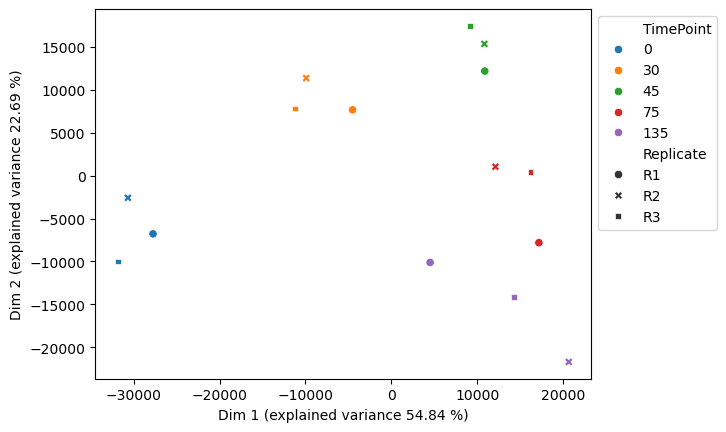

In [22]:
txPCA(tpms[columnOrder])

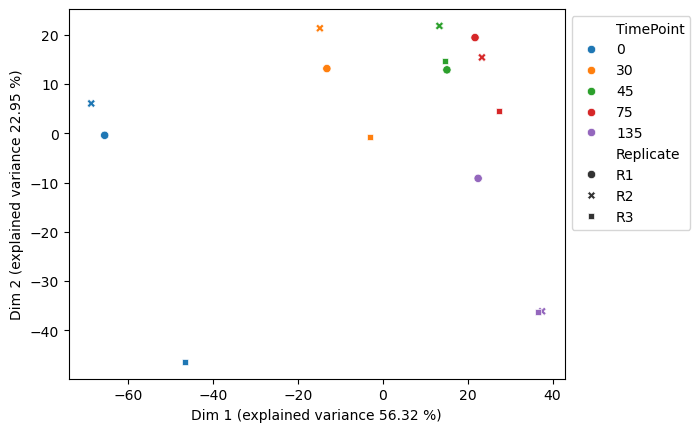

In [23]:
txPCA(logs[columnOrder])

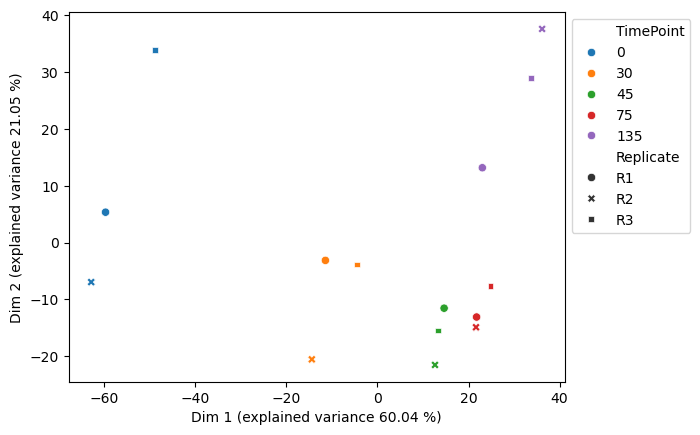

In [24]:
txPCA(logTPMs[columnOrder])

In [25]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

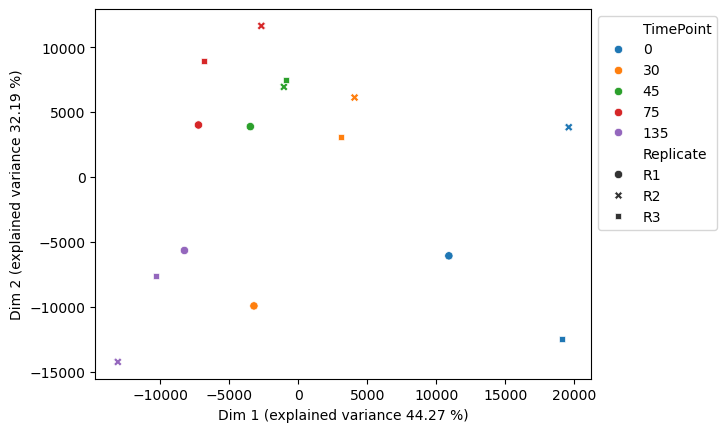

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

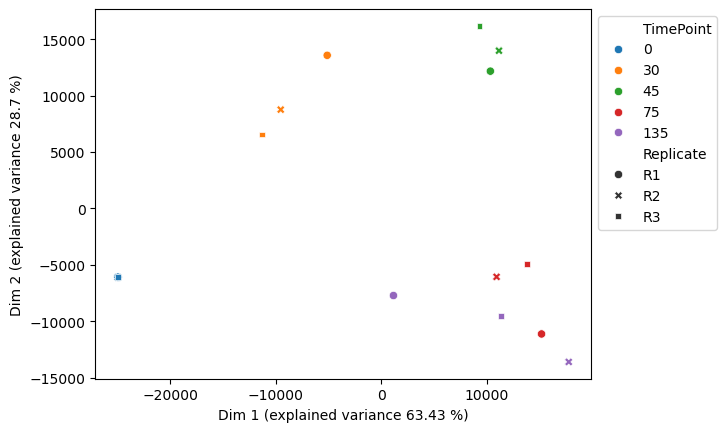

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

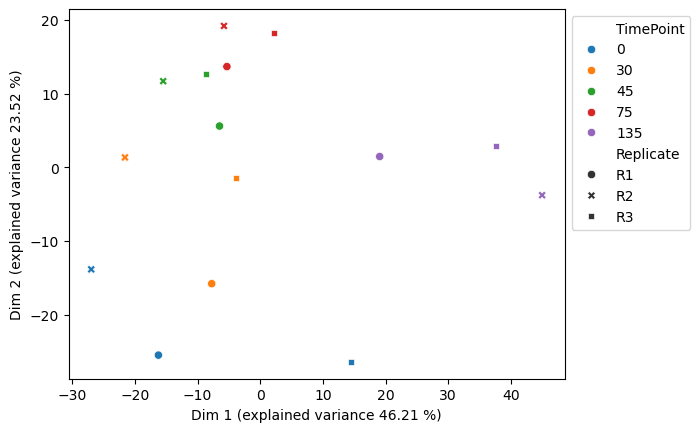

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

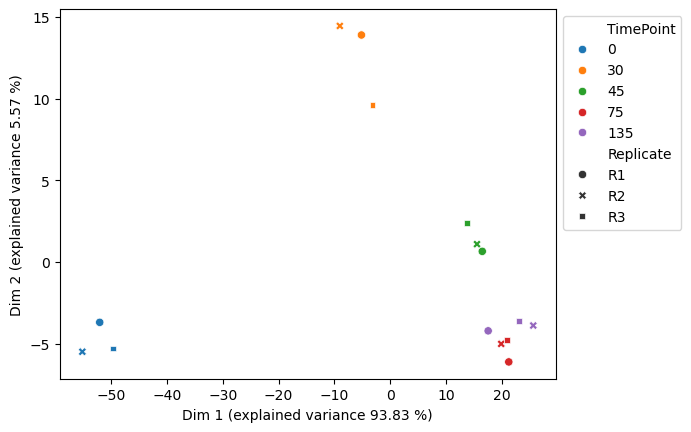

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates not as great, but specific replicate detectable to remove. Especially tpmsHost/logTPMsHost look very scattered.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [30]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '30', '45', '75', '135']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,30,45,75,135,Entity,Symbol
Geneid,,,,,,,
gene-FTB24_16895,2052.738240,1850.195277,713.854932,765.192245,1409.581165,host,None
gene-FTB24_13135,778.827447,849.797083,511.050766,496.749822,919.722111,host,acpP
gene-FTB24_13465,16.991639,16.960073,18.284256,18.618433,18.283766,host,None
gene-FTB24_15975,35.610337,30.962765,25.302402,21.061264,39.054673,host,None
gene-FTB24_02010,7.855970,3.823154,4.265425,5.142591,31.256467,host,None
...,...,...,...,...,...,...,...
gene-FTB24_12985,4.750984,4.102663,3.373756,4.253769,9.291833,host,None
gene-FTB24_03630,42.567945,54.458228,29.264575,27.201470,71.626845,host,None
gene-FTB24_12945,33.434206,23.895000,31.551186,34.389278,29.815591,host,None


In [31]:
TPMsds = TPMsds[['0', '30', '45', '75', '135']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,30,45,75,135,Entity,Symbol
Geneid,,,,,,,
gene-FTB24_16895,776.633131,816.175286,64.225286,69.083870,103.901681,host,None
gene-FTB24_13135,67.925468,162.024786,29.451291,52.574285,86.409030,host,acpP
gene-FTB24_13465,1.122408,2.638081,0.943681,0.628977,1.269985,host,None
gene-FTB24_15975,8.352318,4.345003,2.001470,2.223524,2.672598,host,None
gene-FTB24_02010,1.996593,1.155600,0.474057,0.278758,4.976590,host,None
...,...,...,...,...,...,...,...
gene-FTB24_12985,2.131741,0.716345,0.923369,0.563070,2.369042,host,None
gene-FTB24_03630,10.977734,21.705465,4.520148,4.553975,10.001446,host,None
gene-FTB24_12945,3.933887,1.137731,2.745110,2.192595,0.986518,host,None


In [32]:
propExp = proportionalExp(TPMmeans[['0', '30', '45', '75', '135']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,30,45,75,135,Entity,Symbol
Geneid,,,,,,,
gene-FTB24_16895,1.000000,0.901330,0.347757,0.372767,0.686683,host,None
gene-FTB24_13135,0.846807,0.923972,0.555658,0.540109,1.000000,host,acpP
gene-FTB24_13465,0.912625,0.910929,0.982051,1.000000,0.982025,host,None
gene-FTB24_15975,0.911807,0.792806,0.647871,0.539276,1.000000,host,None
gene-FTB24_02010,0.251339,0.122316,0.136465,0.164529,1.000000,host,None
...,...,...,...,...,...,...,...
gene-FTB24_12985,0.511307,0.441534,0.363088,0.457796,1.000000,host,None
gene-FTB24_03630,0.594302,0.760305,0.408570,0.379766,1.000000,host,None
gene-FTB24_12945,0.972228,0.694839,0.917472,1.000000,0.867003,host,None


## 5. Phage gene classification

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [34]:
# # Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Clostridioides_difficile_strain_TW11"
# t["Phage"] = "Clostridium_phage_JD032"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Li_fractional_expression_T=0.6.tsv", sep="\t")

In [35]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [36]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [37]:
TPMmeans

,0,30,45,75,135,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,
gene-FTB24_16895,2052.738240,1850.195277,713.854932,765.192245,1409.581165,host,None,None,None
gene-FTB24_13135,778.827447,849.797083,511.050766,496.749822,919.722111,host,acpP,None,None
gene-FTB24_13465,16.991639,16.960073,18.284256,18.618433,18.283766,host,None,None,None
gene-FTB24_15975,35.610337,30.962765,25.302402,21.061264,39.054673,host,None,None,None
gene-FTB24_02010,7.855970,3.823154,4.265425,5.142591,31.256467,host,None,None,None
...,...,...,...,...,...,...,...,...,...
gene-FTB24_12985,4.750984,4.102663,3.373756,4.253769,9.291833,host,None,None,None
gene-FTB24_03630,42.567945,54.458228,29.264575,27.201470,71.626845,host,None,None,None
gene-FTB24_12945,33.434206,23.895000,31.551186,34.389278,29.815591,host,None,None,None


In [38]:
TPMmeans.loc[TPMmeans['Entity'] == 'phage'].shape[0]

54

In [39]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      43
middle    11
Name: count, dtype: int64

Add classes to other dfs.

In [40]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] != 'MK473382.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'MK473382.1']
gff3_genes["seq_id"].unique()

array(['CP045224.1', 'CP045225.1', 'MK473382.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [41]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [42]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,45_R1,45_R2,45_R3,75_R1,75_R2,75_R3,135_R1,135_R2,135_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,,
gene-FTB24_16895,1907.164499,1182.739481,3068.310741,2985.970241,1104.193871,1460.421719,685.260013,653.492637,802.812147,792.523505,670.294705,832.758526,1437.647288,1520.458306,1270.637902,host,None,None,None,409.760766
gene-FTB24_13135,810.941563,684.365564,841.175214,1075.438280,702.442667,771.510302,544.077494,516.514531,472.560272,571.085195,460.913425,458.250845,1033.371237,901.790837,824.004259,host,acpP,None,None,54.912389
gene-FTB24_13465,18.401053,16.919280,15.654584,13.315542,18.091501,19.473176,17.862535,19.591663,17.398571,18.431663,19.464981,17.958654,16.984167,17.859986,20.007146,host,None,None,None,0.152704
gene-FTB24_15975,38.203820,24.333756,44.293435,36.744408,26.269714,29.874174,28.044168,23.322536,24.540502,23.845113,18.402955,20.935725,37.270356,42.832370,37.061294,host,None,None,None,2.107343
gene-FTB24_02010,9.819456,5.116923,8.631532,4.087022,2.294475,5.087967,4.407649,4.761696,3.626929,5.192911,4.778816,5.456045,36.022788,33.357871,24.388743,host,None,None,None,11.087498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-FTB24_12985,4.095303,2.530484,7.627165,4.184049,3.187465,4.936474,4.305818,2.115663,3.699785,3.616679,4.158599,4.986027,5.949267,11.160540,10.765693,host,None,None,None,1.327302
gene-FTB24_03630,53.304787,27.488391,46.910658,85.058034,37.053640,41.263011,35.591975,26.888662,25.313088,33.259580,22.279661,26.065170,73.987362,82.524019,58.369156,host,None,None,None,9.335449
gene-FTB24_12945,32.650500,29.056095,38.596023,25.290354,22.503503,23.891143,31.972021,34.683016,27.998521,37.480472,32.632499,33.054862,31.079169,29.696010,28.671595,host,None,None,None,0.646393


In [43]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [44]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [45]:
# Full TPM table
tpms.to_csv('Li_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Li_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Li_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Li_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Li_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Li_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Li_phage_gff3.tsv', sep='\t')